In [1]:
# При изменениях в коде проекте эти обновления будут автоматически подгружаться в ноутбук
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import inspect
import argparse
import numpy as np
from detox import DeToxEdit
import torch

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from utils.startup import main
from evaluation.evaluate_model import evaluate_model

if '__file__' in globals():
    parser = argparse.ArgumentParser(description='DeTox')
    parser.add_argument('--config_file', default='gpt2-medium.ini', type=str, help='Config Filename. E.g. gpt2-medium.ini')
    args = parser.parse_args()
    config_filename = args.config_file
else:
    config_filename = 'gpt2-medium.ini'

config = main(config_filename=config_filename)


/Users/ellina/Documents/Projection Filter for Subspaces/detox-edit/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ellina/Documents/Projection Filter for Subspaces/detox-edit/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No CUDA_VISIBLE_DEVICES found. Setting to 0.
PROJECT_ROOT: 'detox-edit'
PYTHONPATH: 'detox-edit':
HF_HOME: 'detox-edit'


In [3]:
from utils.model_utils import load_large_model
from detox import DeToxEdit

model_id = 'gpt2'
model, tokenizer = load_large_model(model_id)

INFO:root:Model gpt2 loaded.


In [4]:
lower_layer = 10
upper_layer = 24

layer_range = np.arange(lower_layer, upper_layer) if lower_layer != -1 and upper_layer != -1 else None

In [5]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import logging

In [ ]:
# Пути к данным для доменов
data_paths = {
    #"toxicity": "toxicity_pairwise/toxicity.jsonl",
    #"sentiment": "toxicity_pairwise/sentiment.jsonl",
    "clickbait": "toxicity_pairwise/clickbait.jsonl"
}

# Словарь для хранения результатов
results_clickbait = {}

# Обрабатываем данные для каждого домена
for domain, path in data_paths.items():
    print(f"Обрабатываем домен: {domain}")
    
    # Без центрирования
    editor_no_center = editor = DeToxEdit(
    model=model,
    tokenizer=tokenizer,
    pref_data_dps=313,
    centering=False,
    top_k_ranks=2,
    edit_layer_range=layer_range,
    random_dps=True
)
    not_center_ats, not_center_pref_matrix = editor_no_center.get_ats(path)
    
    # С центрированием
    editor_center = DeToxEdit(
    model=model,
    tokenizer=tokenizer,
    pref_data_dps=313,
    centering=True,
    top_k_ranks=2,
    edit_layer_range=layer_range,
    random_dps=True
)
    center_ats, center_pref_matrix = editor_center.get_ats(path)
    
    # Сохраняем результаты
    results[domain] = {
        "not_center_ats": not_center_ats,
        "not_center_pref_matrix": not_center_pref_matrix,
        "center_ats": center_ats,
        "center_pref_matrix": center_pref_matrix
    }

INFO:root:Loaded 313 preferred and 313 non-preferred samples.
INFO:root:Batch 1/6 of size 50


Обрабатываем домен: clickbait


INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Preference matrix calculated.
INFO:root:Loaded 313 preferred and 313 non-preferred samples.
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Siz

Визуализация для домена: clickbait


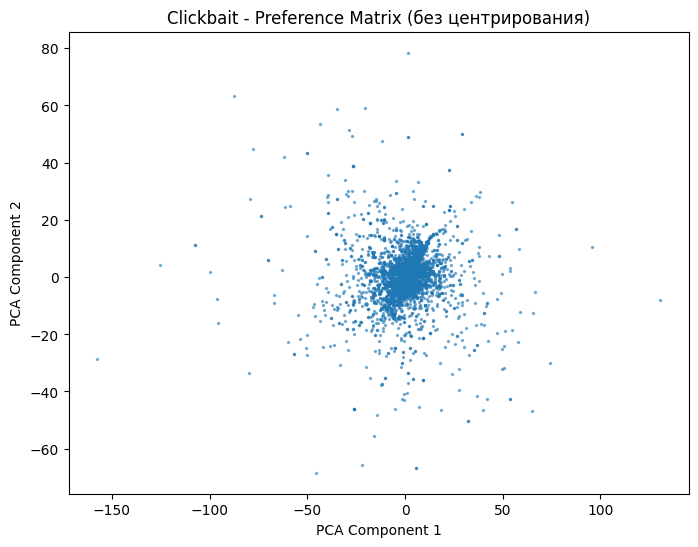

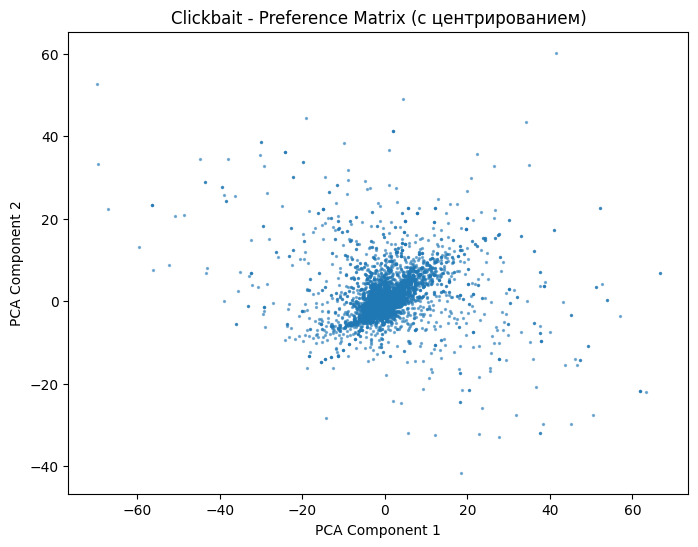

In [8]:
def pca_visualize_preference_matrix(pref_matrix, title):
    """
    Применяет PCA к матрице предпочтений и строит график.
    Args:
        pref_matrix (torch.Tensor): Матрица предпочтений (L, N, D).
        title (str): Заголовок графика.
    """
    from sklearn.decomposition import PCA

    # Конкатенируем все слои
    all_layers = pref_matrix.cpu().numpy().reshape(-1, pref_matrix.shape[-1])  # (L*N, D)
    
    # PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(all_layers)
    
    # Визуализация
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], s=2, alpha=0.5)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# Визуализация для всех доменов
for domain, data in results.items():
    print(f"Визуализация для домена: {domain}")
    
    # Без центрирования
    pca_visualize_preference_matrix(data["not_center_pref_matrix"], 
                                    title=f"{domain.capitalize()} - Preference Matrix (без центрирования)")
    
    # С центрированием
    pca_visualize_preference_matrix(data["center_pref_matrix"], 
                                    title=f"{domain.capitalize()} - Preference Matrix (с центрированием)")


In [9]:
# Пути к данным для доменов
data_paths = {
    "toxicity": "toxicity_pairwise/toxicity.jsonl",
    #"sentiment": "toxicity_pairwise/sentiment.jsonl",
    #"clickbait": "toxicity_pairwise/clickbait.jsonl"
}

# Словарь для хранения результатов
results_toxicity = {}

# Обрабатываем данные для каждого домена
for domain, path in data_paths.items():
    print(f"Обрабатываем домен: {domain}")
    
    # Без центрирования
    editor_no_center = editor = DeToxEdit(
    model=model,
    tokenizer=tokenizer,
    pref_data_dps=313,
    centering=False,
    top_k_ranks=2,
    edit_layer_range=layer_range,
    random_dps=True
)
    not_center_ats, not_center_pref_matrix = editor_no_center.get_ats(path)
    
    # С центрированием
    editor_center = DeToxEdit(
    model=model,
    tokenizer=tokenizer,
    pref_data_dps=313,
    centering=True,
    top_k_ranks=2,
    edit_layer_range=layer_range,
    random_dps=True
)
    center_ats, center_pref_matrix = editor_center.get_ats(path)
    
    # Сохраняем результаты
    results_toxicity[domain] = {
        "not_center_ats": not_center_ats,
        "not_center_pref_matrix": not_center_pref_matrix,
        "center_ats": center_ats,
        "center_pref_matrix": center_pref_matrix
    }

Обрабатываем домен: toxicity


INFO:root:Loaded 313 preferred and 313 non-preferred samples.
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Preference matrix calculated.
INFO:root:Loaded 313 preferred and 313 non-preferred samples.
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
I

Визуализация для домена: toxicity


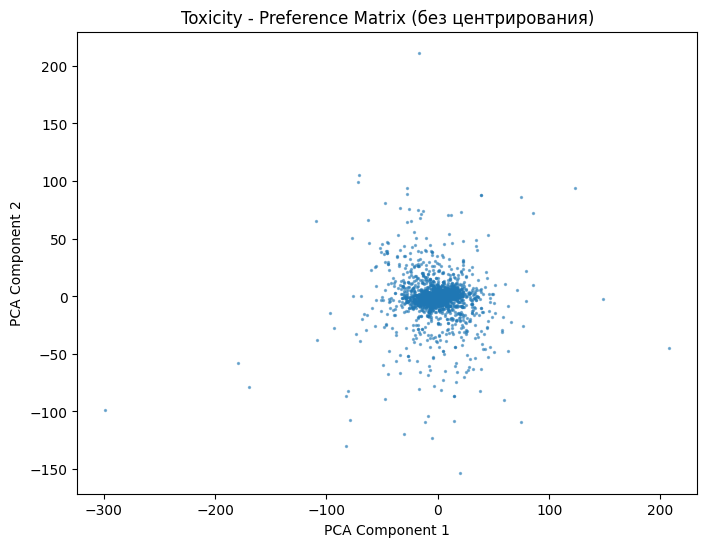

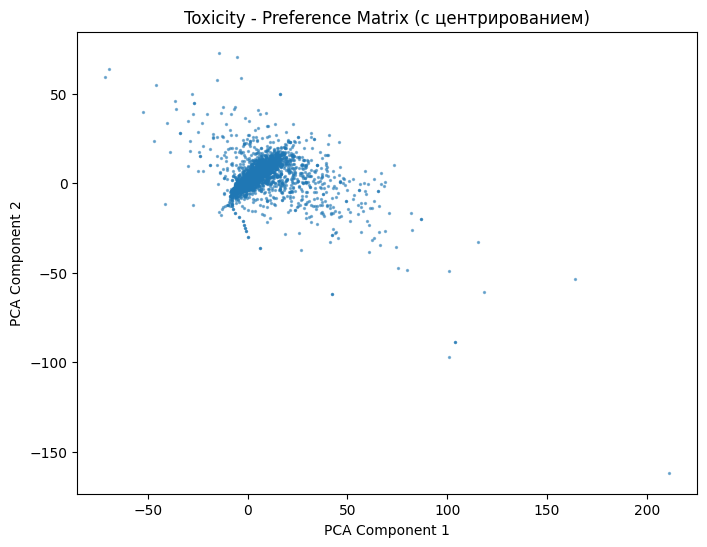

In [10]:
def pca_visualize_preference_matrix(pref_matrix, title):
    """
    Применяет PCA к матрице предпочтений и строит график.
    Args:
        pref_matrix (torch.Tensor): Матрица предпочтений (L, N, D).
        title (str): Заголовок графика.
    """
    from sklearn.decomposition import PCA

    # Конкатенируем все слои
    all_layers = pref_matrix.cpu().numpy().reshape(-1, pref_matrix.shape[-1])  # (L*N, D)
    
    # PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(all_layers)
    
    # Визуализация
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], s=2, alpha=0.5)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# Визуализация для всех доменов
for domain, data in results_toxicity.items():
    print(f"Визуализация для домена: {domain}")
    
    # Без центрирования
    pca_visualize_preference_matrix(data["not_center_pref_matrix"], 
                                    title=f"{domain.capitalize()} - Preference Matrix (без центрирования)")
    
    # С центрированием
    pca_visualize_preference_matrix(data["center_pref_matrix"], 
                                    title=f"{domain.capitalize()} - Preference Matrix (с центрированием)")


In [11]:
def pca_visualize_multi_domains(results_dicts, title):
    """
    Применяет PCA к матрицам предпочтений из нескольких доменов и строит общий график.
    Args:
        results_dicts (dict): Словарь с результатами для доменов.
        title (str): Заголовок графика.
    """
    from sklearn.decomposition import PCA
    
    combined_layers = []
    domain_labels = []

    # Собираем данные для каждого домена
    for domain, results in results_dicts.items():
        for subdomain, data in results.items():
            pref_matrix_1 = data["not_center_pref_matrix"].cpu().numpy().reshape(-1, data["not_center_pref_matrix"].shape[-1])
            pref_matrix_2 = data["center_pref_matrix"].cpu().numpy().reshape(-1, data["center_pref_matrix"].shape[-1])
            
            # Добавляем в общий список
            combined_layers.append(pref_matrix_1)
            domain_labels.extend([f"{domain}-без центрирования"] * len(pref_matrix_1))
            combined_layers.append(pref_matrix_2)
            domain_labels.extend([f"{domain}-с центрированием"] * len(pref_matrix_2))
    
    # Конкатенируем данные
    combined_layers = np.vstack(combined_layers)

    # PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(combined_layers)

    # Визуализация
    plt.figure(figsize=(10, 8))
    unique_labels = list(set(domain_labels))
    colors = ["blue", "orange", "green", "red"]  # Задаем цвета

    for i, label in enumerate(unique_labels):
        indices = [idx for idx, lbl in enumerate(domain_labels) if lbl == label]
        plt.scatter(reduced[indices, 0], reduced[indices, 1], s=2, alpha=0.5, label=label, color=colors[i % len(colors)])

    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()


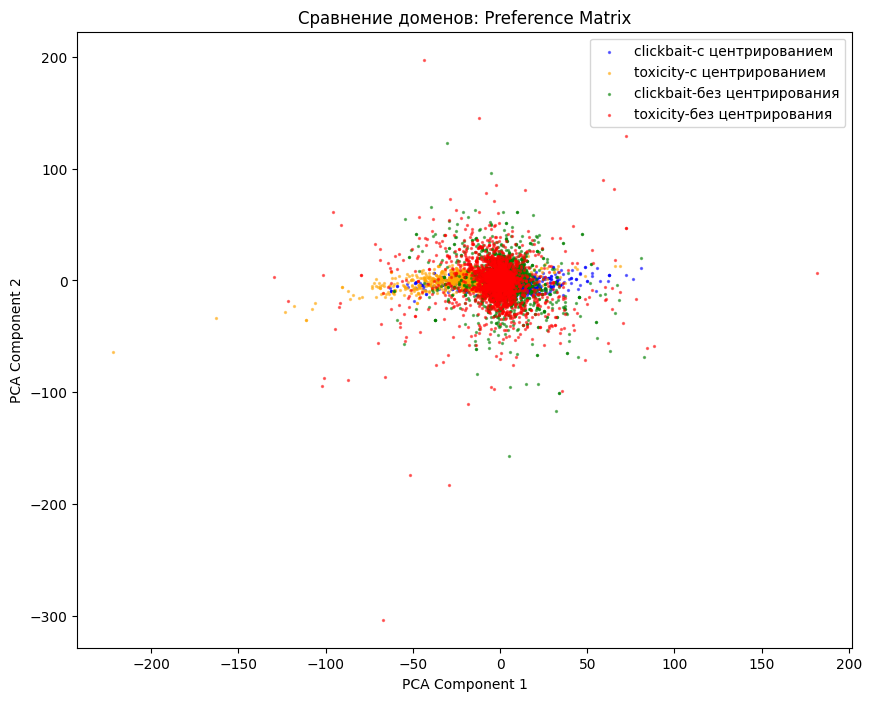

In [13]:
# Визуализация для нескольких доменов
pca_visualize_multi_domains(
    results_dicts={"toxicity": results_toxicity, "clickbait": results}, 
    title="Сравнение доменов: Preference Matrix"
)


In [14]:
def pca_visualize_pref_matrices(pref_matrix_1, pref_matrix_2, title, labels=("Без центрирования", "С центрированием")):
    """
    Применяет PCA к двум матрицам предпочтений и строит один график.
    Args:
        pref_matrix_1 (torch.Tensor): Первая матрица предпочтений (L, N, D).
        pref_matrix_2 (torch.Tensor): Вторая матрица предпочтений (L, N, D).
        title (str): Заголовок графика.
        labels (tuple): Метки для легенды.
    """
    from sklearn.decomposition import PCA
    
    # Конкатенируем слои обеих матриц
    all_layers_1 = pref_matrix_1.cpu().numpy().reshape(-1, pref_matrix_1.shape[-1])  # (L*N, D)
    all_layers_2 = pref_matrix_2.cpu().numpy().reshape(-1, pref_matrix_2.shape[-1])  # (L*N, D)
    
    # Объединяем обе матрицы для общего PCA
    combined_layers = np.vstack((all_layers_1, all_layers_2))
    
    # PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(combined_layers)
    
    # Разделяем результаты для каждой матрицы
    reduced_1 = reduced[:len(all_layers_1)]
    reduced_2 = reduced[len(all_layers_1):]
    
    # Визуализация
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_1[:, 0], reduced_1[:, 1], s=2, alpha=0.5, label=labels[0], color="blue")
    plt.scatter(reduced_2[:, 0], reduced_2[:, 1], s=2, alpha=0.5, label=labels[1], color="orange")
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()


Визуализация для домена: toxicity
Сравнение для поддомена: toxicity


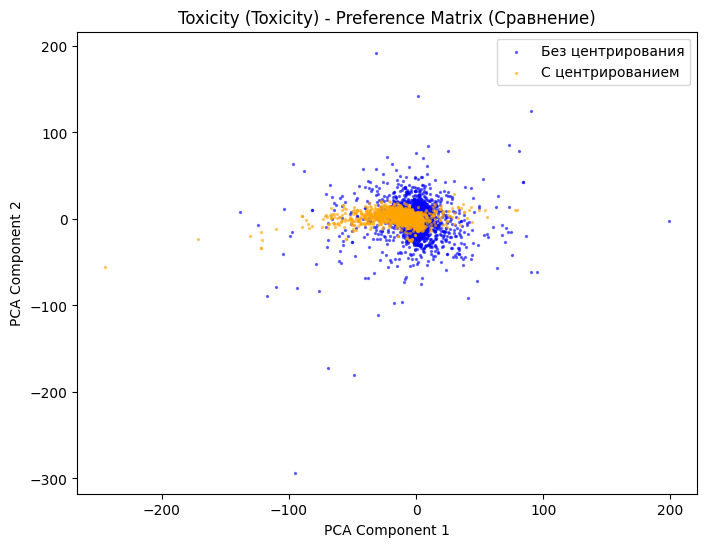

Визуализация для домена: clickbait
Сравнение для поддомена: clickbait


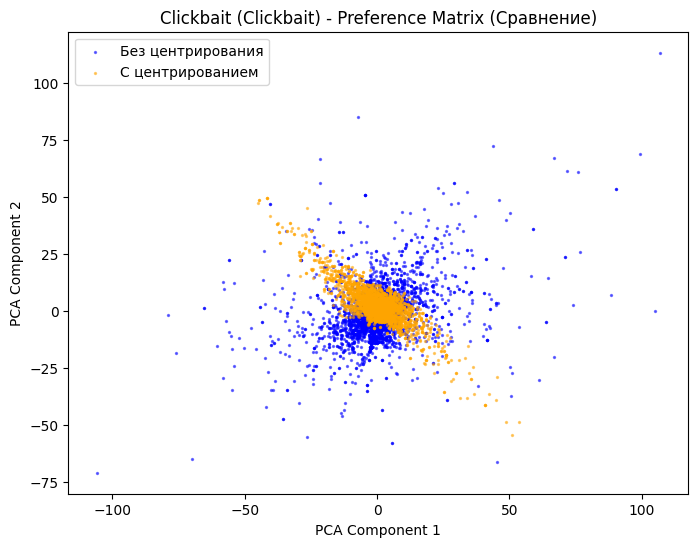

In [16]:
# Обработка словарей результатов
results_dicts = {"toxicity": results_toxicity, "clickbait": results}

for domain, results in results_dicts.items():
    print(f"Визуализация для домена: {domain}")
    
    # Перебор данных в results
    for subdomain, data in results.items():
        print(f"Сравнение для поддомена: {subdomain}")
        
        # Построение графика
        pca_visualize_pref_matrices(
            pref_matrix_1=data["not_center_pref_matrix"], 
            pref_matrix_2=data["center_pref_matrix"], 
            title=f"{subdomain.capitalize()} ({domain.capitalize()}) - Preference Matrix (Сравнение)",
            labels=("Без центрирования", "С центрированием")
        )


In [ ]:
# Пути к данным для доменов
data_paths = {
    #"toxicity": "toxicity_pairwise/toxicity.jsonl",
    "sentiment": "toxicity_pairwise/sentiment.jsonl",
    #"clickbait": "toxicity_pairwise/clickbait.jsonl"
}

# Словарь для хранения результатов
results_sentiment = {}

# Обрабатываем данные для каждого домена
for domain, path in data_paths.items():
    print(f"Обрабатываем домен: {domain}")
    
    # Без центрирования
    editor_no_center = editor = DeToxEdit(
    model=model,
    tokenizer=tokenizer,
    pref_data_dps=313,
    centering=False,
    top_k_ranks=2,
    edit_layer_range=layer_range,
    random_dps=True
)
    not_center_ats, not_center_pref_matrix = editor_no_center.get_ats(path)
    
    # С центрированием
    editor_center = DeToxEdit(
    model=model,
    tokenizer=tokenizer,
    pref_data_dps=313,
    centering=True,
    top_k_ranks=2,
    edit_layer_range=layer_range,
    random_dps=True
)
    center_ats, center_pref_matrix = editor_center.get_ats(path)
    
    # Сохраняем результаты
    results_sentiment[domain] = {
        "not_center_ats": not_center_ats,
        "not_center_pref_matrix": not_center_pref_matrix,
        "center_ats": center_ats,
        "center_pref_matrix": center_pref_matrix
    }

INFO:root:Loaded 313 preferred and 313 non-preferred samples.
INFO:root:Batch 1/6 of size 50


Обрабатываем домен: sentiment
